In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras

IMAGE_PATH = os.path.abspath(os.getcwd())
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(os.path.abspath(os.getcwd()), fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


In [2]:
from tf_agents.environments import suite_gym

env = suite_gym.load("ALE/SpaceInvaders-v5")
env

A.L.E: Arcade Learning Environment (version 0.7.4+069f8bd)
[Powered by Stella]
/opt/anaconda3/envs/py38tf-last/lib/python3.8/site-packages/gym/utils/seeding.py:138: DeprecationWarning: WARN: Function `hash_seed(seed, max_bytes)` is marked as deprecated and will be removed in the future. 
  deprecation(
/opt/anaconda3/envs/py38tf-last/lib/python3.8/site-packages/gym/utils/seeding.py:175: DeprecationWarning: WARN: Function `_bigint_from_bytes(bytes)` is marked as deprecated and will be removed in the future. 
  deprecation(


In [3]:
print(env.get_info())
print(env.action_spec())
print(env.gym.get_action_meanings())

None
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=5)
['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


Saving figure invader-plot


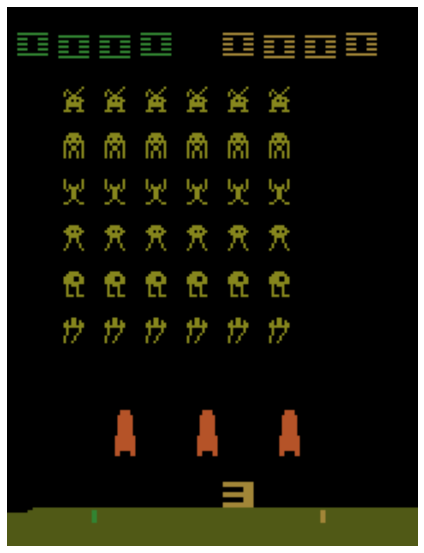

In [4]:
img = env.render(mode="rgb_array")

plt.figure(figsize=(6, 8))
plt.imshow(img)
plt.axis("off")
save_fig("invader-plot")
plt.show()

In [5]:
from tf_agents.environments.wrappers import ActionRepeat
from gym.wrappers import TimeLimit
from tf_agents.environments.atari_preprocessing import AtariPreprocessing
from tf_agents.environments.atari_wrappers import FrameStack4

repeating_env = ActionRepeat(env, times=4)
limited_repeating_env = suite_gym.load(
    "SpaceInvaders-v4",
    gym_env_wrappers=[lambda env: TimeLimit(env, max_episode_steps=10000)],
    env_wrappers=[lambda env: ActionRepeat(env, times=4)]
)
env = suite_gym.load(
    'SpaceInvaders-v4',
    max_episode_steps=27000,
    gym_env_wrappers=[AtariPreprocessing, FrameStack4]
)

In [6]:
import numpy as np

def draw_obs(obs): #Draw the Observation Screen
    bs = obs.astype(np.float32)
    img = obs[..., :3]
    current_frame_delta = np.maximum(obs[..., 3] - obs[..., :3].mean(axis=-1), 0.)
    img[..., 0] += current_frame_delta
    img[..., 2] += current_frame_delta
    img = np.clip(img / 150, 0, 1)
    plt.imshow(img)
    plt.axis("off")


/opt/anaconda3/envs/py38tf-last/lib/python3.8/site-packages/gym/utils/seeding.py:47: DeprecationWarning: WARN: Function `rng.randint(low, [high, size, dtype])` is marked as deprecated and will be removed in the future. Please use `rng.integers(low, [high, size, dtype])` instead.
  deprecation(


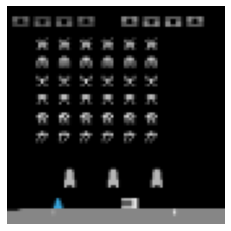

In [7]:
env.seed(32)

env.reset()
for _ in range(4): #Test control and get the trajectory
    time_step = env.step(3)

draw_obs(time_step.observation)
# save_fig('processed_invadar_game_pic')
plt.show()

In [8]:
from tf_agents.environments import TFPyEnvironment
import keras
import tensorflow as tf
from tf_agents.networks.q_network import QNetwork

tf_env = TFPyEnvironment(env)

proprocessing_layer = keras.layers.Lambda(lambda obs: tf.cast(obs, np.float32) / 255.) #Default layer design from book
fc_layer_params = [512]
conv_layer_params = [(32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1)]
q_net = QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    preprocessing_layers=proprocessing_layer,
    conv_layer_params=conv_layer_params,
    fc_layer_params=fc_layer_params
)


In [9]:
from tf_agents.agents.dqn.dqn_agent import DqnAgent

train_steps = tf.Variable(0)
update_period = 4
optimizer = tf.keras.optimizers.RMSprop(learning_rate=2.5e-4, rho=0.95, momentum=0.0)
epsilon_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=0.1,
    decay_steps=250000 // update_period,
    end_learning_rate=0.01)
agent = DqnAgent(
    time_step_spec=tf_env.time_step_spec(),
    action_spec=tf_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    target_update_period=2000,
    td_errors_loss_fn=keras.losses.Huber(reduction="none"),
    gamma=0.99,
    train_step_counter=train_steps,
    epsilon_greedy=lambda:epsilon_fn(train_steps)
)
agent.initialize()

2022-03-29 14:36:22.912231: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
agent

In [11]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.replay_buffers.py_hashed_replay_buffer import PyHashedReplayBuffer

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=500000
)

replay_buffer_observer = replay_buffer.add_batch

In [12]:
class ShowProgress():
    def __init__(self, total):
        self.counter = 0
        self.total = total
    def __call__(self, trajectory):
        if not trajectory.is_boundary():
            self.counter += 1
        if self.counter % 100 == 0:
            print("\r{}/{}".format(self.counter, self.total), end="")

In [13]:
from tf_agents.metrics import tf_metrics

train_metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(),
    tf_metrics.AverageEpisodeLengthMetric()
]

In [14]:
from tf_agents.eval.metric_utils import log_metrics
import logging

logging.getLogger().setLevel(logging.INFO)
log_metrics(train_metrics)

INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 0
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


In [15]:
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver

collect_driver = DynamicStepDriver(
    tf_env,
    agent.collect_policy,
    observers=[replay_buffer_observer] + train_metrics,
    num_steps=update_period
)

In [16]:
collect_driver

In [18]:
from tf_agents.policies.random_tf_policy import RandomTFPolicy

initial_collect_policy = RandomTFPolicy(tf_env.time_step_spec(), tf_env.action_spec())

init_driver = DynamicStepDriver(
    tf_env,
    initial_collect_policy,
    observers=[replay_buffer.add_batch, ShowProgress(20000)],
    num_steps=1000
)
final_time_step, final_policy_state = init_driver.run()

1000/20000

In [19]:
trajectories, buffer_info = replay_buffer.get_next(sample_batch_size=2, num_steps=3)
print(trajectories)
print(buffer_info)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Trajectory(
{'action': <tf.Tensor: shape=(2, 3), dtype=int64, numpy=
array([[0, 3, 3],
       [2, 1, 3]])>,
 'discount': <tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 1., 1.],
       [1., 1., 1.]], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)>,
 'observation': <tf.Tensor: shape=(2, 3, 84, 84, 4), dtype=uint8, numpy=
array([[[[[ 0,  0,  0,  0],
          [ 0,  0,  0,  0],
          [ 0,  0,  0,  0],
          ...,
          [ 0,  0,  0,  0],
          [ 0,  0,  0,  0],
          [ 0,  0,  0,  0]],

         [[ 0,  0,  0,  0],
          [ 0,  0,  0,  0],
          [ 0,  0,  0,  0],
          ...,
          [ 0,  0,  0,  0],
          [ 0,  0,  0,  0],
          [ 0,  0,  0,  0]],

         [[ 0,  0,  0,  0],
          [ 0,  0,  0,  0],
          [ 0,  0,  0,  0],
          ...,
          [ 0,  0,  0,  0],
          [ 0,  0,  0,  0],
          [ 0,  0,  0,  0]],

         ...,

         [[

In [29]:
print(trajectories._fields)

('step_type', 'observation', 'action', 'policy_info', 'next_step_type', 'reward', 'discount')


In [30]:
print('Shape of \'observation\': ', trajectories.observation.shape)
print('Shape of \'rewards\': ', trajectories.reward.shape)
print(trajectories.step_type.numpy())

Shape of 'observation':  (2, 3, 84, 84, 4)
Shape of 'rewards':  (2, 3)
[[1 1 1]
 [1 1 1]]


Saving figure sub_episode_plot


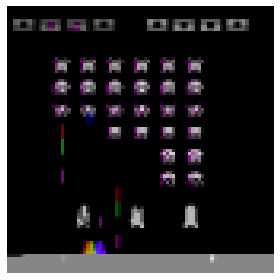

In [31]:
plt.figure(figsize=(6, 4))
for row in range(2):
    for col in range(3):
        plt.plot(2, 3, row*3 + col+1)
        draw_obs(trajectories.observation[row, col].numpy())
plt.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0.02)
save_fig('sub_episode_plot')
plt.show()